# Cross model predictions

This notebook discusses predictions made on datasets for which it has not been trained. This includes using models trained for dataset D to predict on dataset F and G, models trained on dataset F to predict on datset D and G, and so on.

The stateless version of the API is used in order to provide more flexibility. For the stateless API, additional returned variables such as *maxEnrolWindow* and *indexColumn* not present in the simpler notebooks can be seen. The functionality of this notebook exceeds the primary intents for the high-level API, and thus does not follow the same recipe as the *basic examples*. Understanding of the implemented python methods is not required in order to interpret the results, and therefore the implementation is not discussed in detail.

Determining whether machine learning models trained on some facility can be used to make predictions for other facilities is of great interest. If so, the need to gather training data for new facilities may be eliminated, enabling the use of predictive maintenance from the get-go. To decide whether models used in this manner possess any predictive capabilities, results are presented where models trained for each facility are used to perform predictions for the remaining facilities. Determining whether models possess any meaningful predictive capabilities is difficult in itself, but particularly so when used across facilities. Thorough analysis of both the underlying data sources may be required to understand the variations and differences in predictions, and even then the model performance may not be explainable. Examining the model parameters is out of the question due to the amount of trainable weights, except for linear models.

A single architecture for LSTM and MLP models is used in all cases, with one hidden layer of 128 neurons. Some combinations of predicted dataset, trained dataset and predictive model of particular interest are discussed below.

In [1]:
# %load 4_pred_cross_mod.py
import src.core_stateless as mlModule
import src.core_configs as configs

Using TensorFlow backend.


## Required methods

A method is implemented to fetch configs, define models and make predictions based on a directory, model and resolution as input parameters. Each combination of these three parameters provides a predefinend set of dataset specifics found in the *src.core_configs* file.

In [2]:
def trainModelsWithConfig(dirr, mod, res, retrain=False):
    filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig(dirr, mod, res)

    relevantColumns, columnDescriptions, columnUnits, columnNames, df = mlModule.initDataframe(filename, columns, irrelevantColumns)
    df = df[columnOrder]
    df_train, df_test = mlModule.getTestTrainSplit(df, traintime, testtime)
    X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(df_train, df_test, targetColumns)

    mlp = mlModule.MLP('MLP 1x128 d0.2 '+dirr+' mod'+mod, X_train, y_train, layers=[128], dropout=0.2)
    lstm = mlModule.LSTM('LSTM 1x128 d0.2 '+dirr+' mod'+mod, X_train, y_train, layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
    linear = mlModule.Linear_Regularized('Linear rCV ' + dirr + ' mod' + mod, X_train, y_train)

    modelList = [
        mlp,
        lstm,
        linear,
    ]

    maxEnrolWindow, indexColumn = mlModule.initModels(modelList, df_test)
    mlModule.trainModels(modelList, filename, targetColumns, retrain)

    return modelList

A method is implemented to predict with a provided config for a provided model list. Because each defined model is initiated with its own input and output scaler based on the provided training data, these scalers must be redefined for each time predictions with a different dataset are to be made. Following this, predictions are made and plotted.

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def predictWithConfig(modelList, dirr, mod, res):
	filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig(dirr, mod, res)

	relevantColumns, columnDescriptions, columnUnits, columnNames, df = mlModule.initDataframe(filename, columns, irrelevantColumns)
	df = df[columnOrder]
	df_train, df_test = mlModule.getTestTrainSplit(df, traintime, testtime)
	X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(df_train, df_test, targetColumns)
	maxEnrolWindow, indexColumn = mlModule.initModels(modelList, df_test)

	inputScaler = StandardScaler()
	inputScaler.fit(X_train)
	outputScaler = StandardScaler()
	outputScaler.fit(y_train)

	for model in modelList:
		model.inputScaler = inputScaler
		model.outputScaler = outputScaler

	modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
		modelList,
		X_train,
		y_train,
		X_test,
		y_test,
		targetColumns,
		indexColumn,
		columnDescriptions,
		columnUnits,
		traintime,
		plot=True,
		interpol=False,
	)

## Define directories, models and resolution to be used for predictions

The three datasets *D*, *F* and *G* are chosen. The models *A* and *B* as defined in the thesis are chosen as well. A resolution of 30min is chosen. Do note that this resolution will not be used for the *D* dataset as this only offers 6 hour prediction intervals.

In [ ]:
dirrs = ['D', 'F', 'G']
mods = ['A', 'B']
res = '30min'

## Loop the desired prediction models (A and B), and make predictions for each dataset.

Predictions are made in bulks in order to increase the readability of the output, using the below function for each pair of (Model, Dataset). Note that the model parameter is called *mod* and the Dataset paramter is called *dirr*.

In [4]:
def makePredictionsForModAndDir(mod, dirr, dirrs, res, retrain=False):
    allModels = []
    for dirrr in dirrs:
        print("")
        print("Training/loading models for dataset " + dirrr)
        print("Model " + mod)
        print("Resolution " + res)
        print("")
        modelList = trainModelsWithConfig(dirrr, mod, res, retrain)
        allModels.append(modelList)

    for i in range(len(allModels)):
        modelsOfTypei = list(map(lambda x : x[i], allModels))
        print("")
        print("Predictions and deviations for dataset " + dirr)
        print("Model " + mod)
        print("Resolution " + res)
        print("")
        predictWithConfig(modelsOfTypei, dirr, mod, res)

## Facility D, model A, resolution 360min


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model MLP 1x128 d0.2 D mo

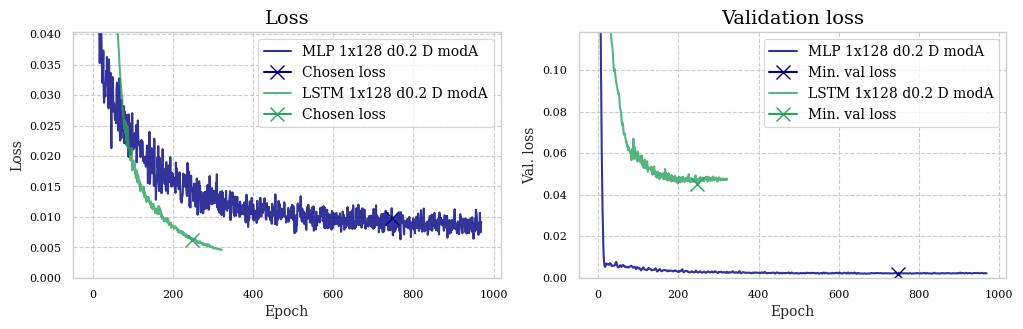


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

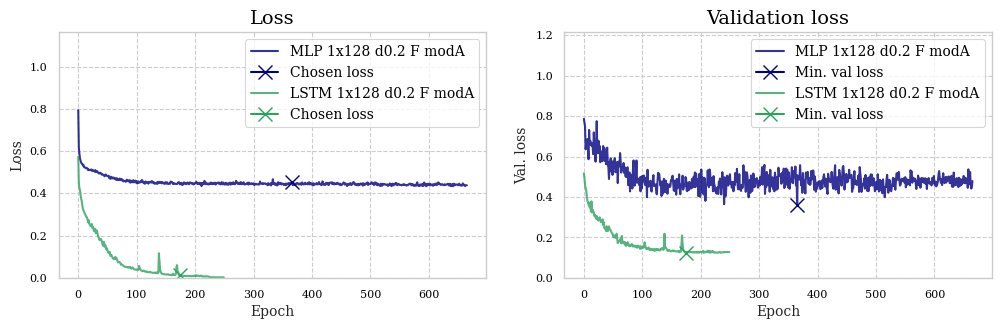


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modA was loaded from file
Model LSTM 1x128 d0.2 G mod

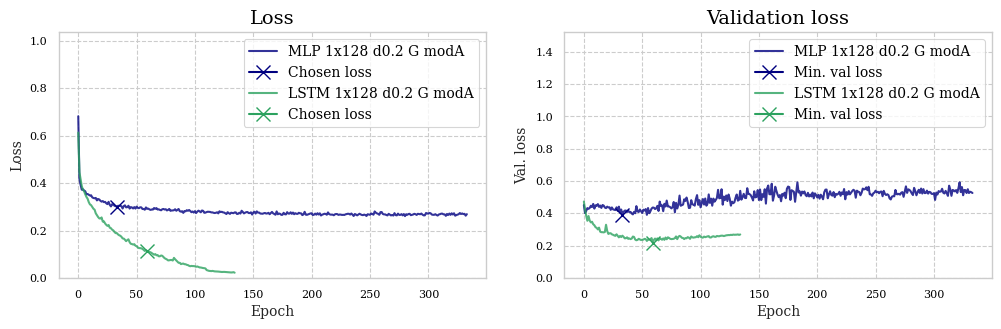


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

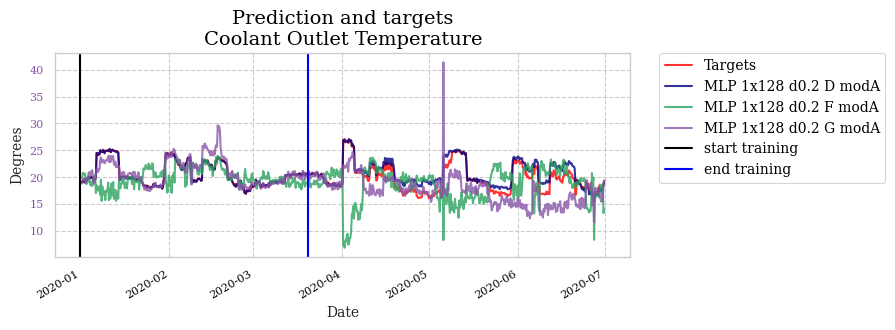

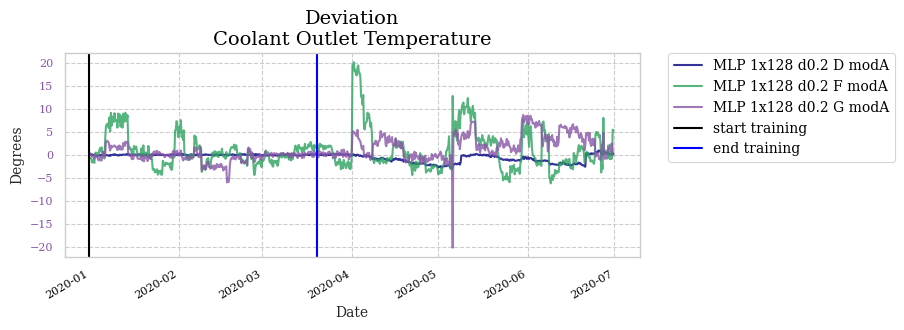

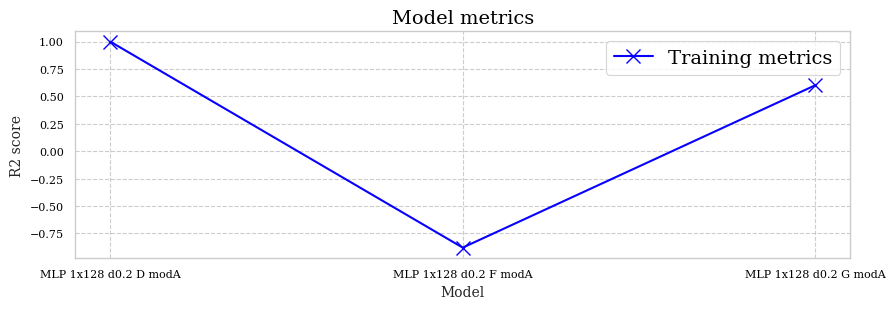


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

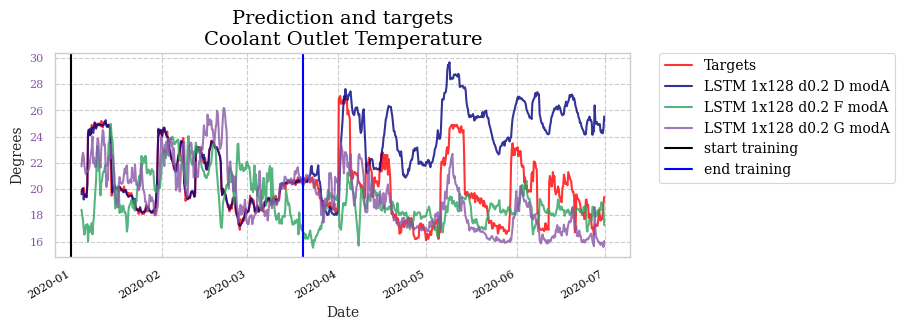

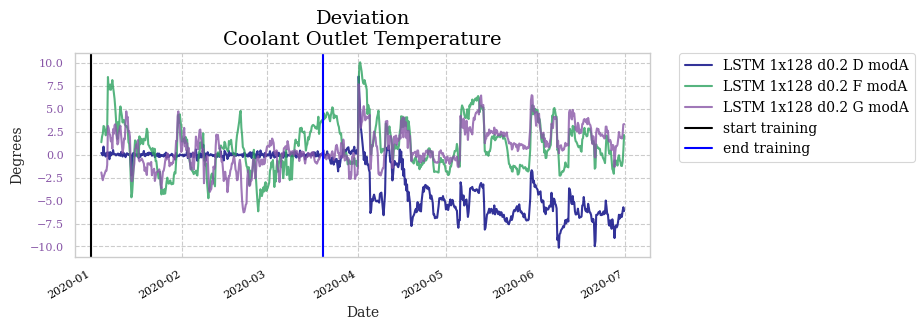

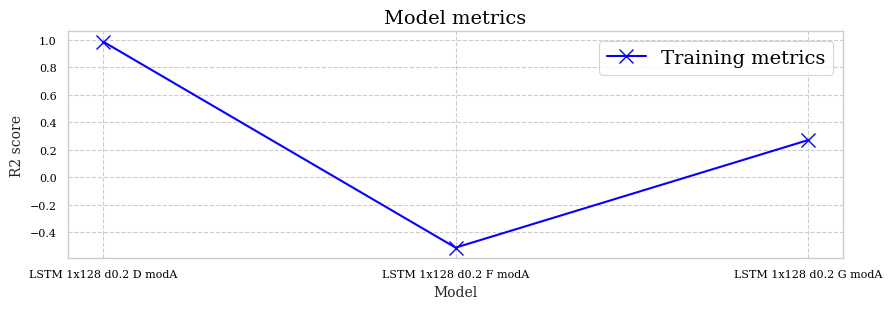


Predictions and deviations for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model prediction score

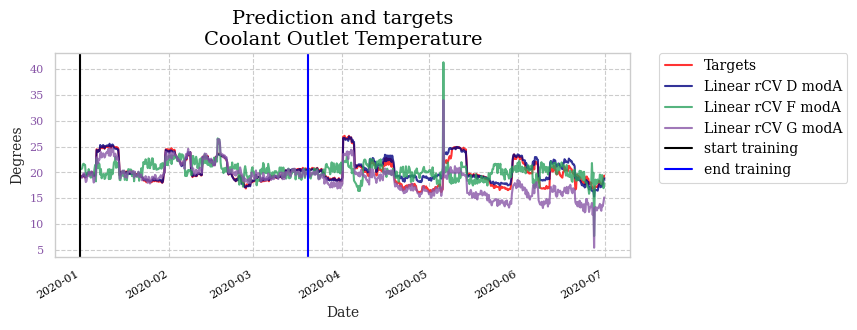

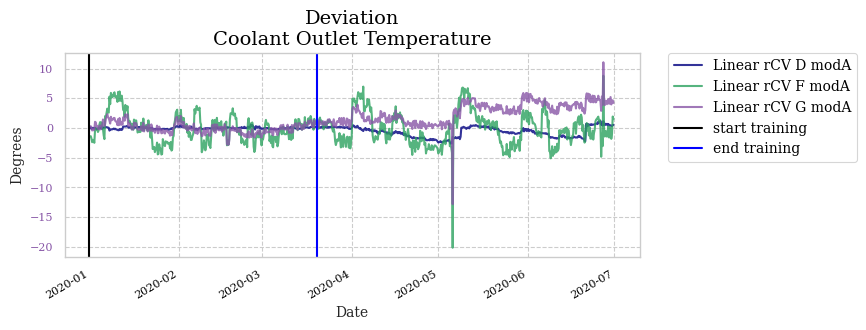

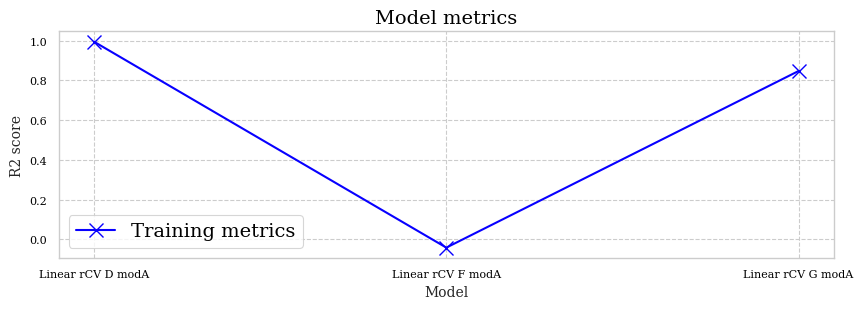

In [5]:
makePredictionsForModAndDir('A', 'D', dirrs, res, retrain=False)

## Discussion, facility D, model A, resolution 360min
Models trained on other datasets are shown not to generalize well for facility D, neither using predictive model A nor B. Although the R2 score calculated on the training set is acceptable at times, it becomes apparent by looking at the plots that the predictions do not follow the expected fouling pattern. Recurrent models were previously established to perform poorly for dataset D in general. The MLP trained on dataset G seems to follow the general trends, however with substantial errors, with two outliers in particular around timestamps 2020.05 and 2020.07. The linear models perform similarly, capturing the general trends but with too substantial error to produce a deviation pattern similar to the added levels of fouling.

## Facility F, model A, resolution 30min


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model MLP 1x128 d0.2 D mo

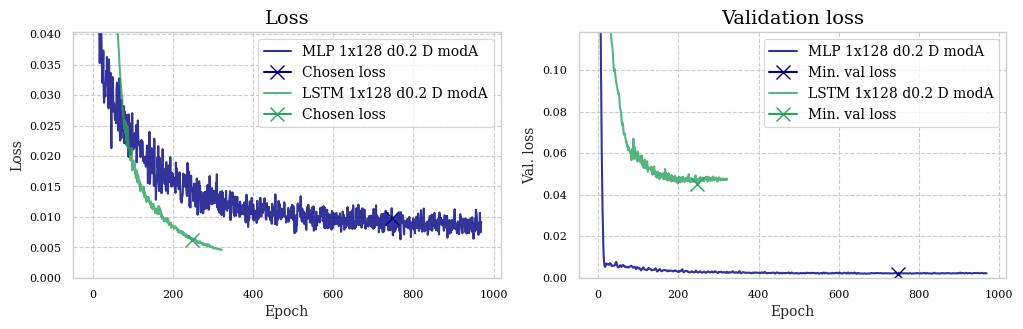


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

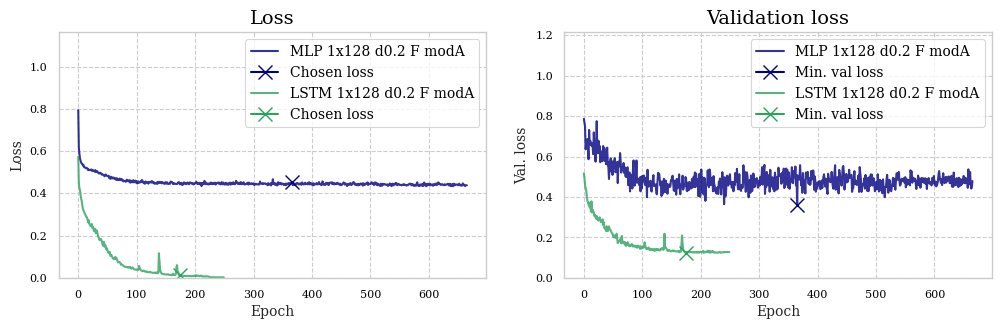


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modA was loaded from file
Model LSTM 1x128 d0.2 G mod

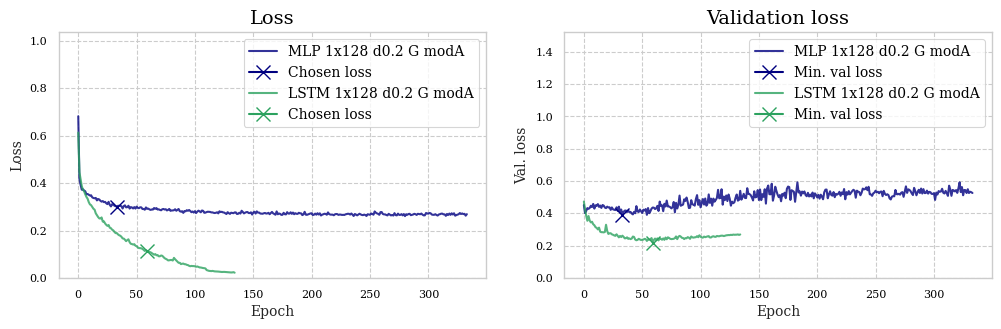


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

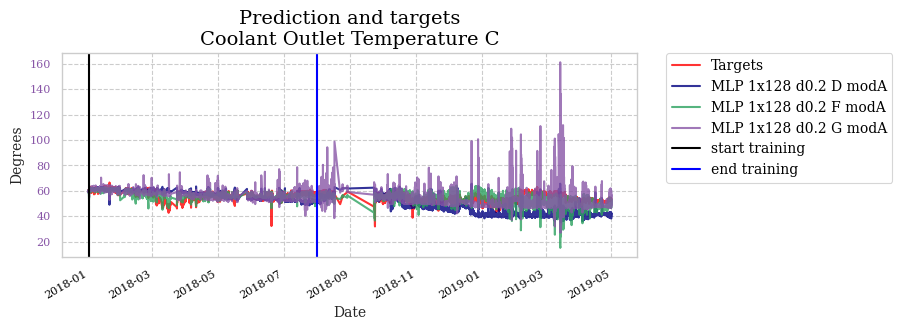

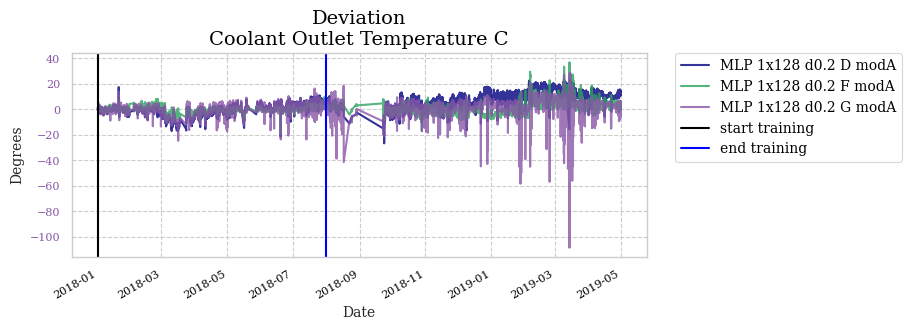

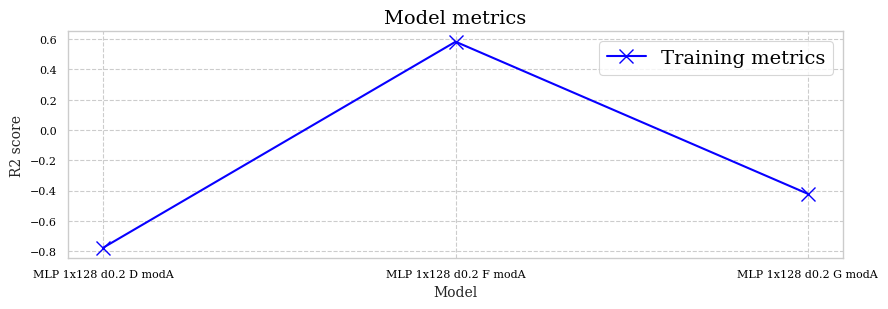


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

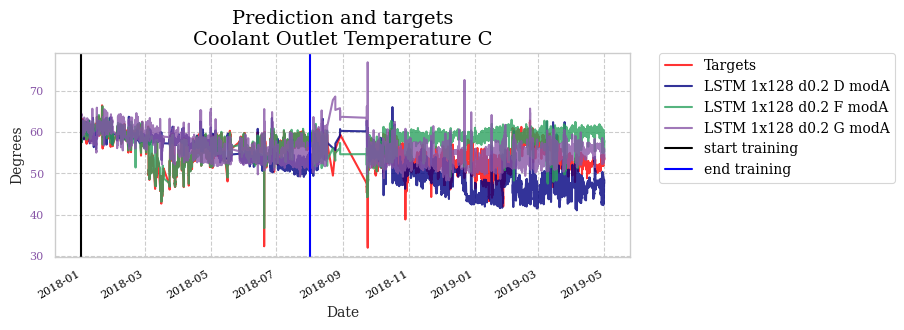

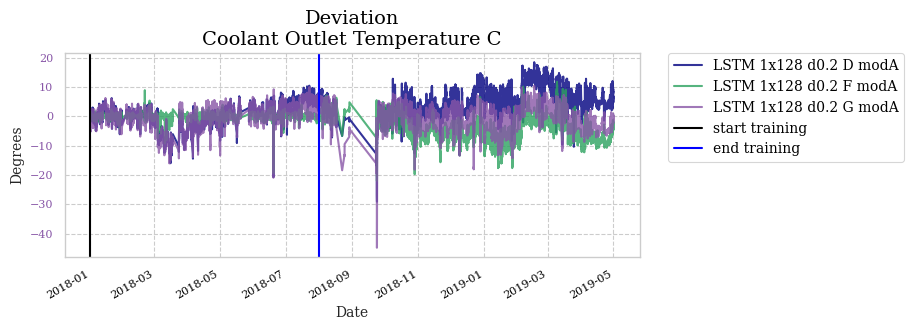

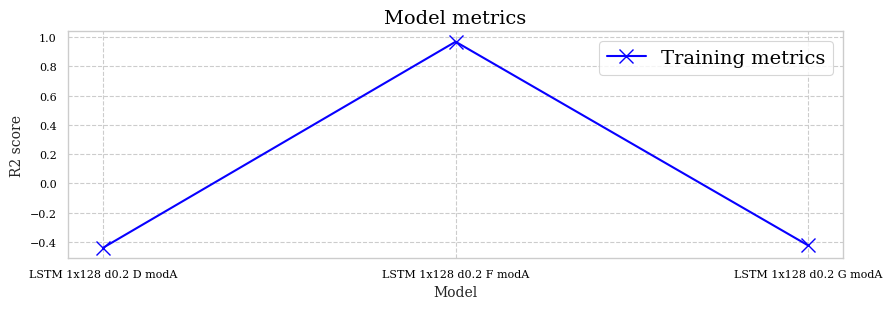


Predictions and deviations for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

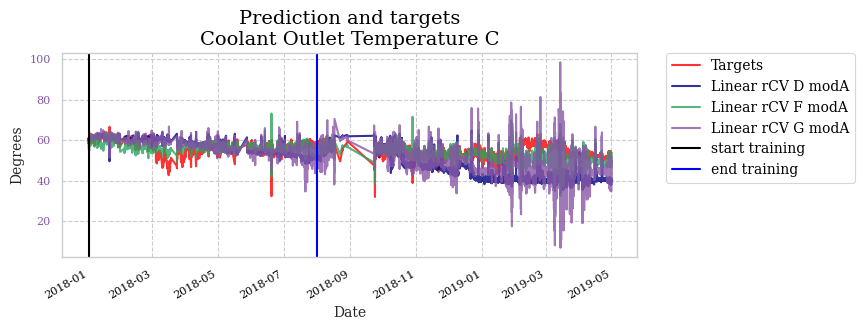

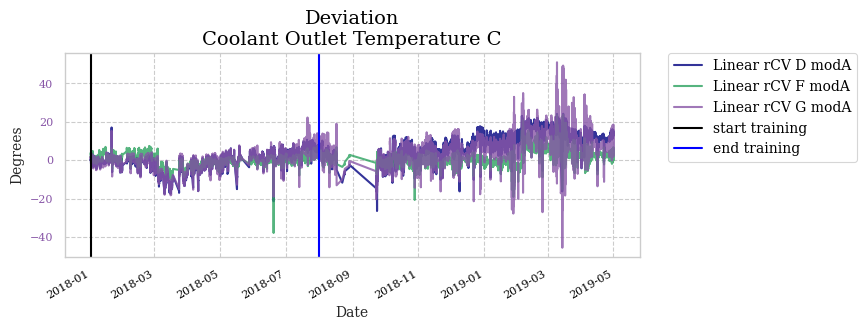

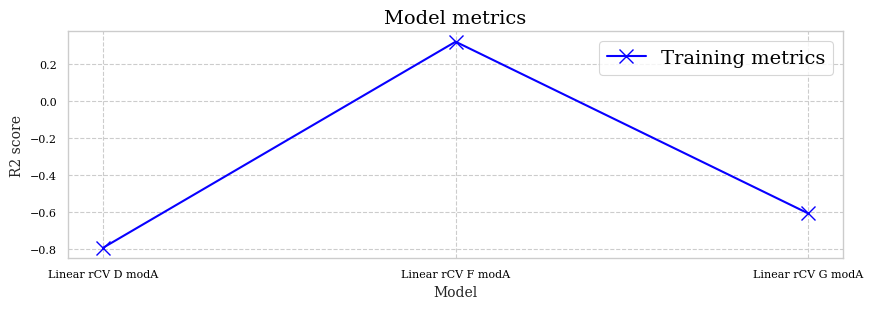

In [6]:
makePredictionsForModAndDir('A', 'F', dirrs, res, retrain=False)

## Discussion, facility F, model A, resolution 30min

For facility F, the MLP model trained on dataset G using predictive model A shows particularly large deviations, often predicting output values wrong by several orders of magnitude, while also displaying large variations. The corresponding MLP model trained on dataset D shows a gradual decrease in predicted value with little variation. LSTM models show some of the same behavior, with gradually decreasing values, although with more variations than the linear model. The same can be said for linear models using predictive model B. Neither model correlates well with the model trained on dataset F.

## Facility G, model A, resolution 30min


Training/loading models for dataset D
Model A
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model MLP 1x128 d0.2 D mo

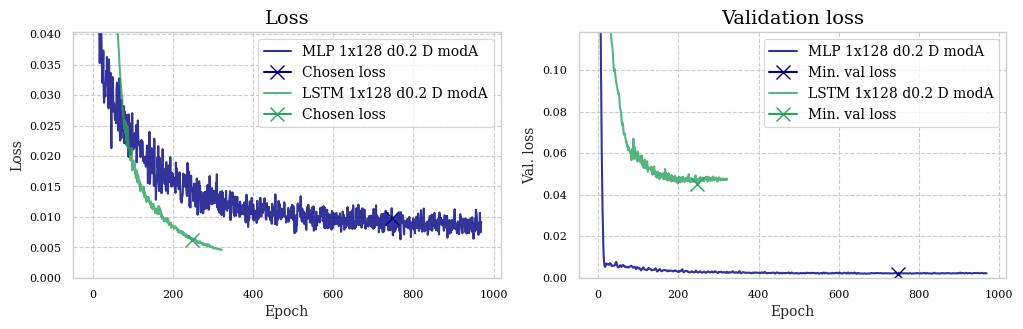


Training/loading models for dataset F
Model A
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

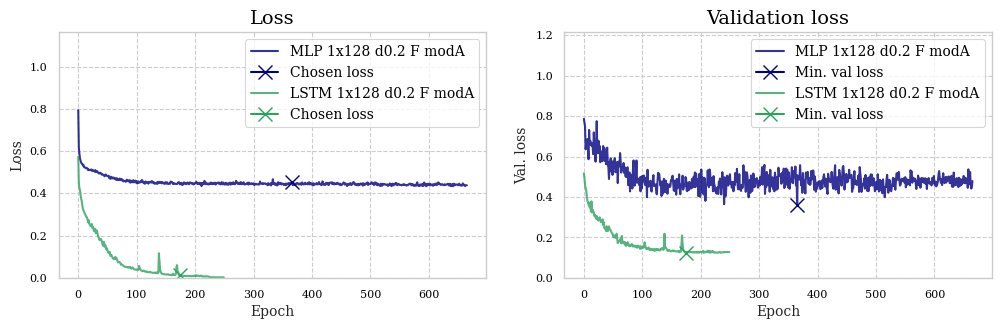


Training/loading models for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modA was loaded from file
Model LSTM 1x128 d0.2 G mod

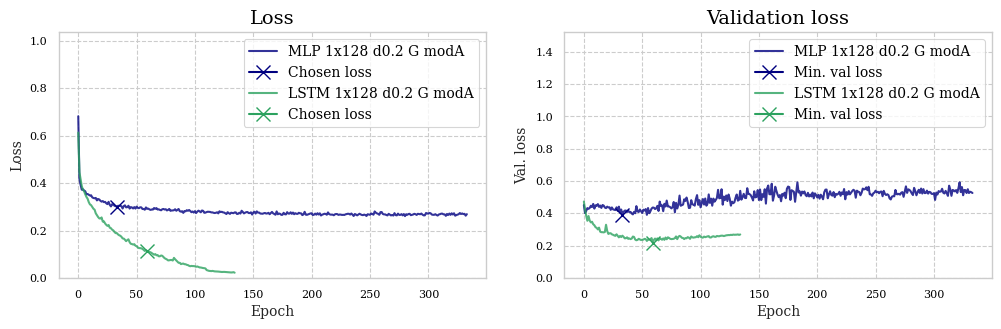


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+-----------------------+-------------+----------

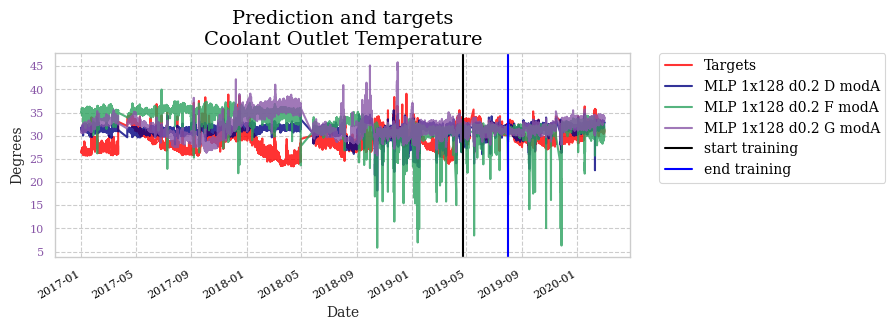

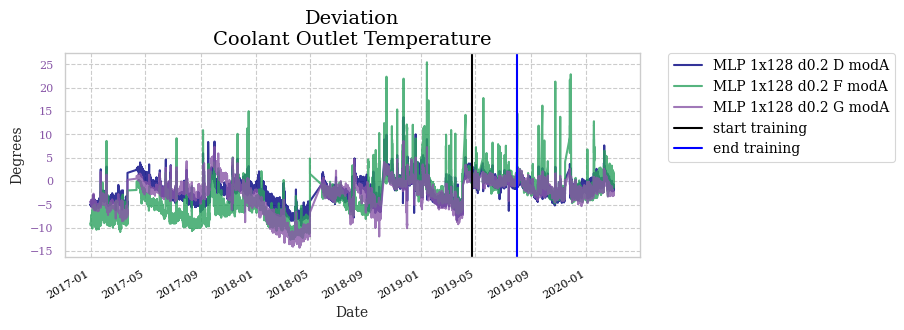

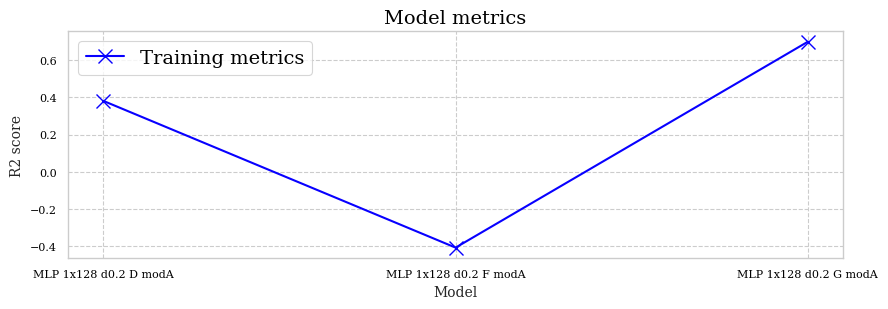


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------------------------+-------------+---------

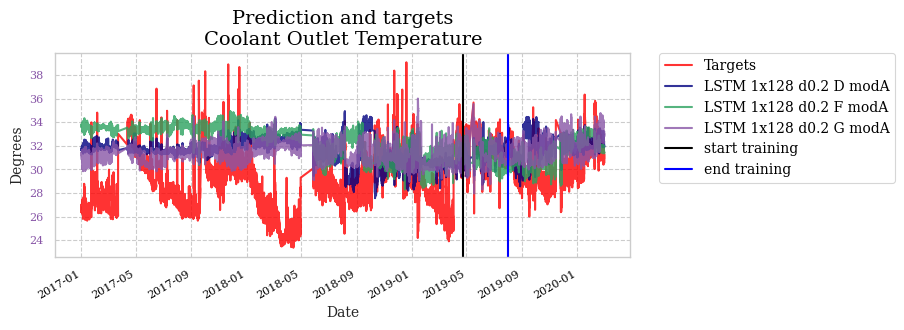

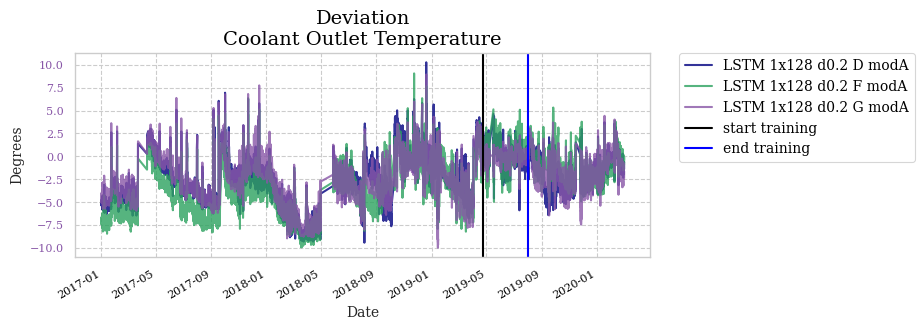

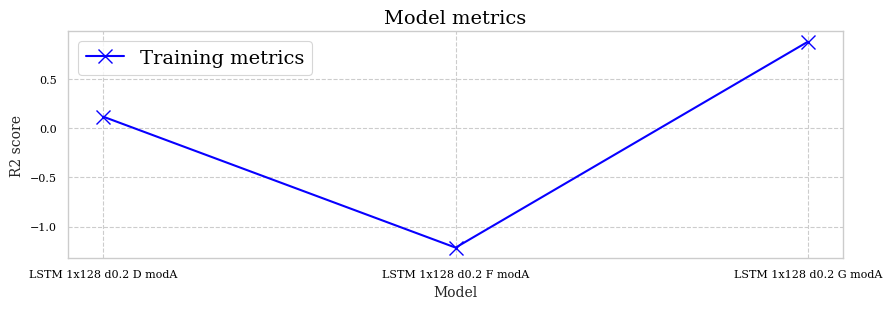


Predictions and deviations for dataset G
Model A
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+-------------------+-------------+------------+


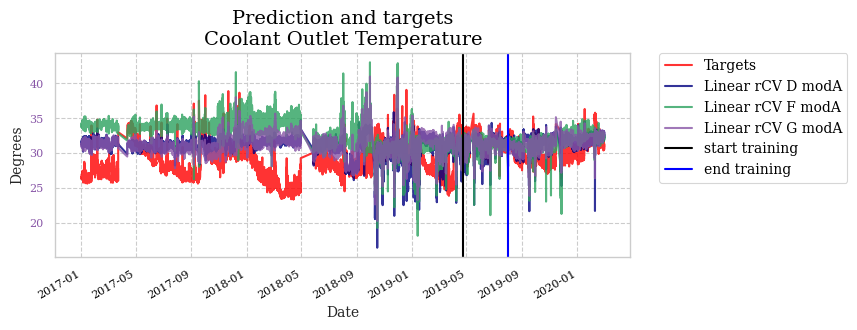

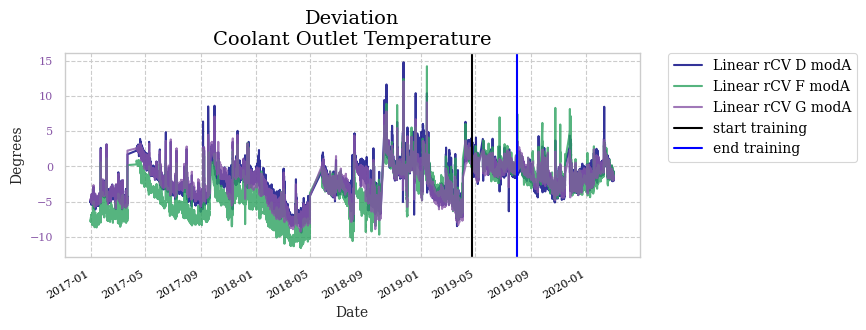

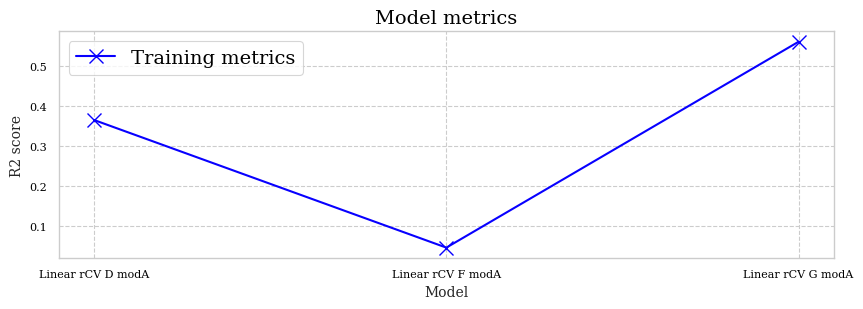

In [7]:
makePredictionsForModAndDir('A', 'G', dirrs, res, retrain=False)

## Discussion, facility G, model A, resolution 30min

It is difficult to evaluate the model performances on facility G appropriately, because the coolant outlet temperature itself is decreasing in a pattern somewhat similar to the expected fouling pattern. This means almost any predictor, even one predicting a constant value, may result in a deviation graph which corresponds to the assumed fouling levels. Even when considering this, cross model prediction for facility G appears more promising than for the facilities previously discussed when using predictive model B. The calculated R2 metrics are relatively high considering the models are trained on different datasets. For MLP models, models trained on dataset D and F show less signs of overfitting to the valve opening value than the model trained on dataset G. All LSTM models show almost the same prediction pattern, although with some static differences. The deviation curves have very similar patterns. The predictions may become even more accurate if static differences are accounted for by adding a derived constant term to the predictions for each model. Linear models seem to have much of the same valve opening overfitting problems.

## Facility D, model B, resolution 360min


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


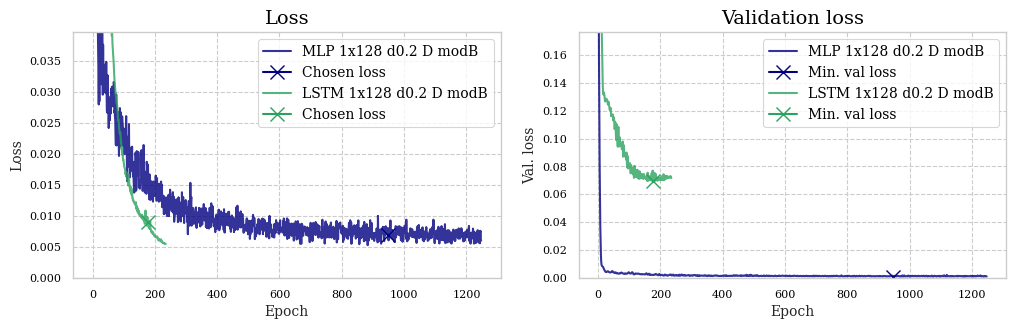


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

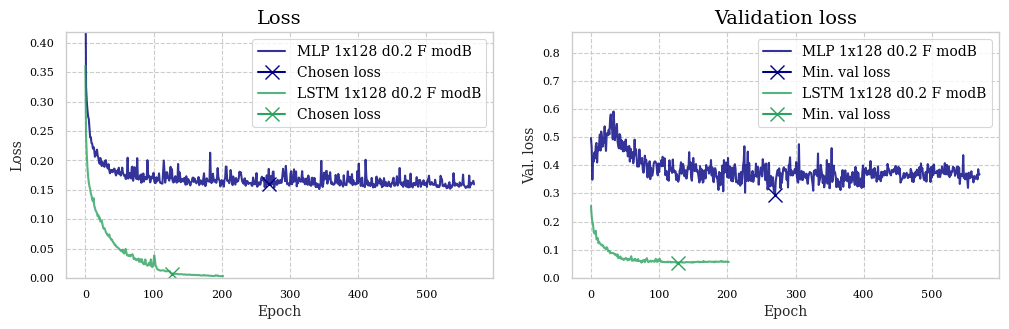


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modB was lo

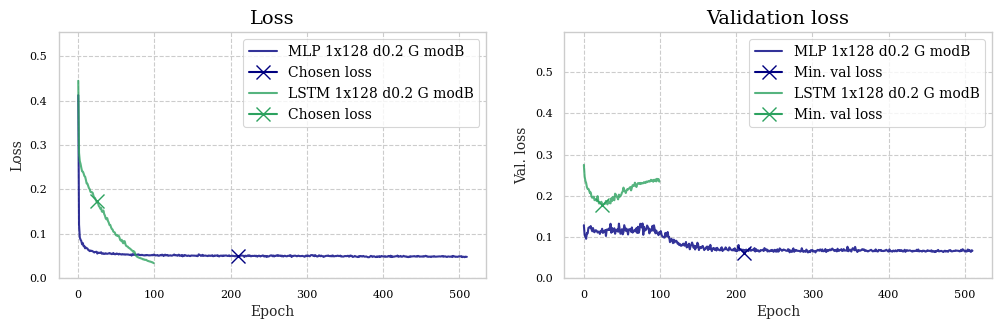


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

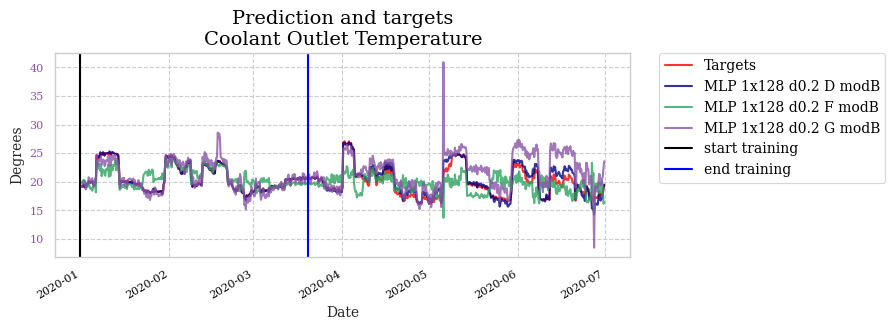

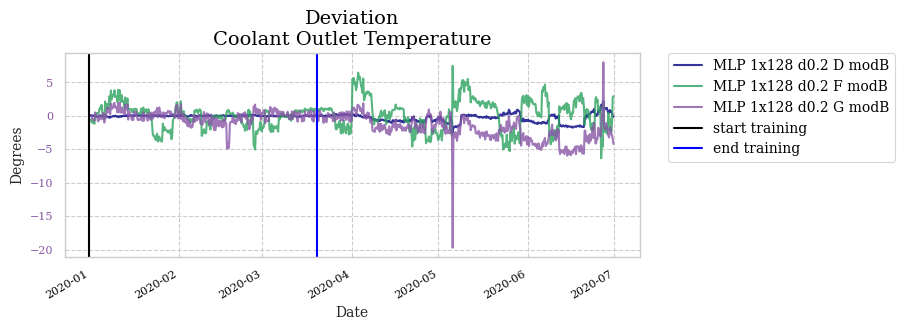

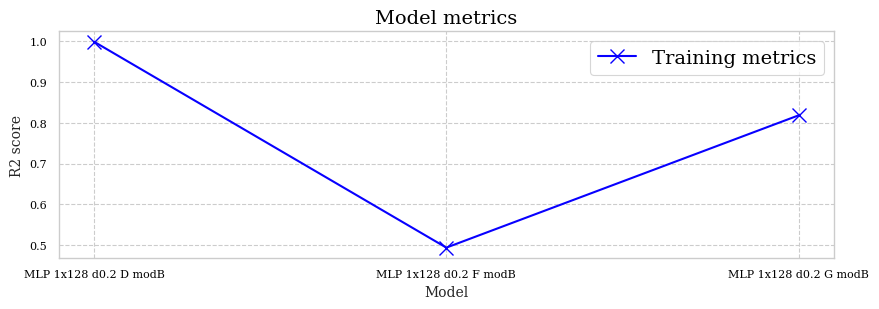


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

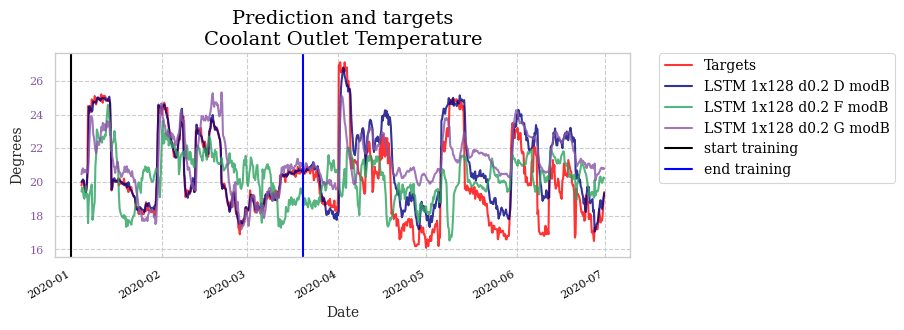

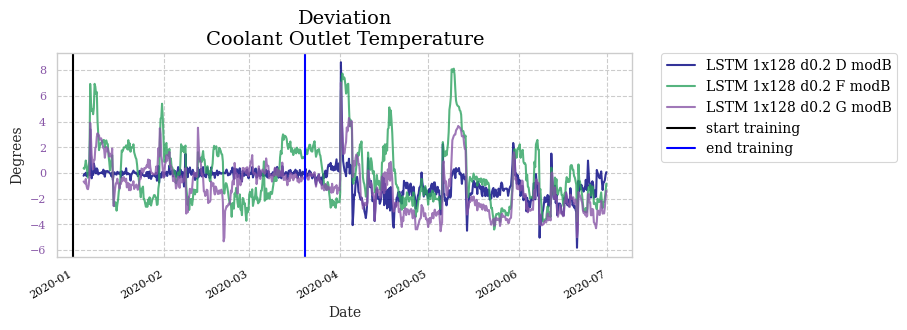

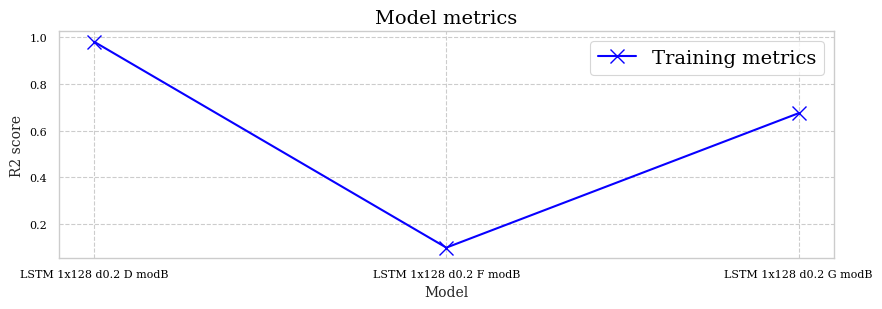


Predictions and deviations for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:

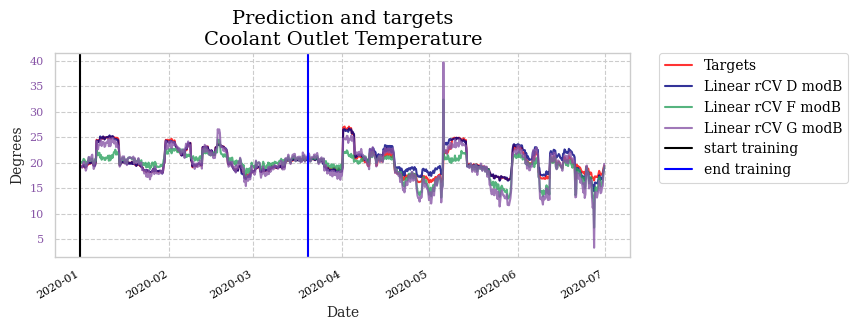

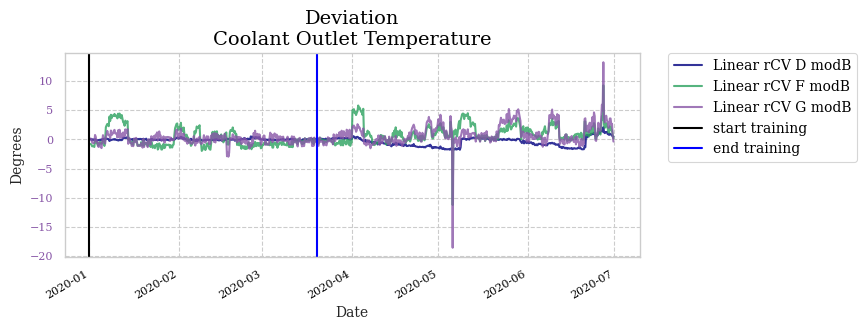

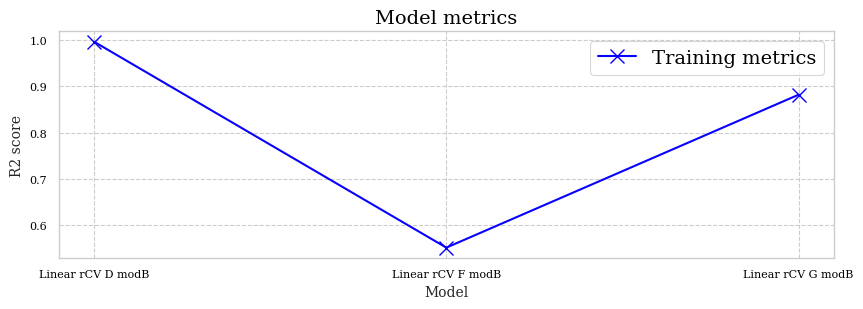

In [8]:
makePredictionsForModAndDir('B', 'D', dirrs, res, retrain=False)

## Discussion, facility D, model B, resolution 360min
Models trained on other datasets are shown not to generalize well for facility D, neither using predictive model A nor B. Although the R2 score calculated on the training set is acceptable at times, it becomes apparent by looking at the plots that the predictions do not follow the expected fouling pattern. Recurrent models were previously established to perform poorly for dataset D in general. The MLP trained on dataset G seems to follow the general trends, however with substantial errors, with two outliers in particular around timestamps 2020.05 and 2020.07. The linear models perform similarly, capturing the general trends but with too substantial error to produce a deviation pattern similar to the added levels of fouling.

## Facility F, model B, resolution 30min


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


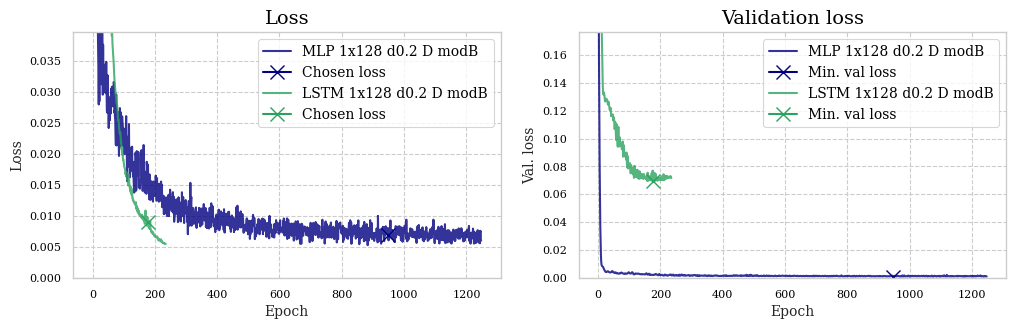


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

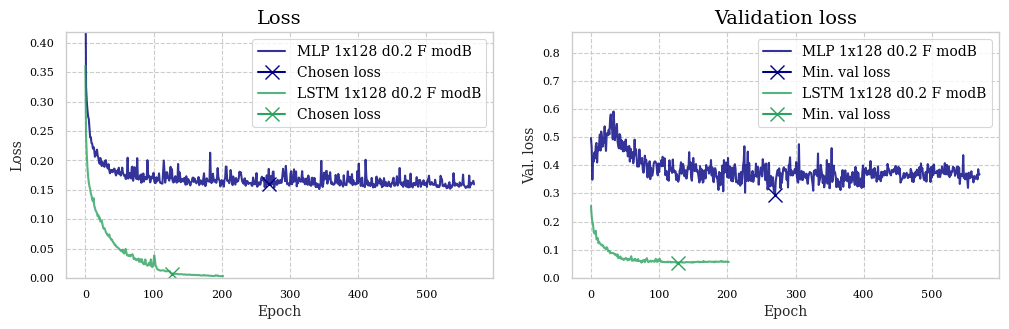


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modB was lo

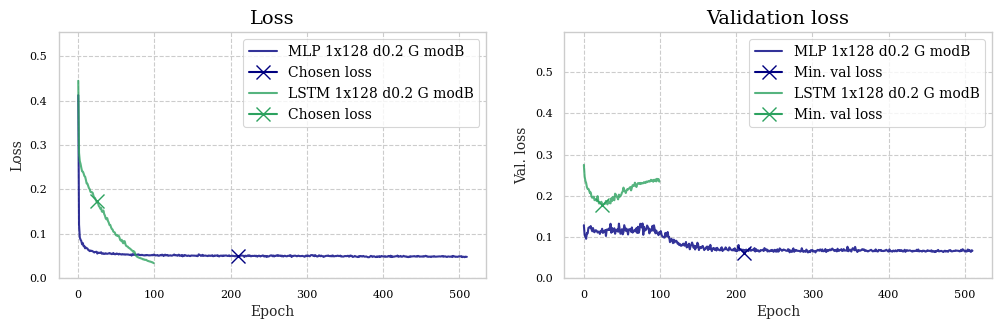


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

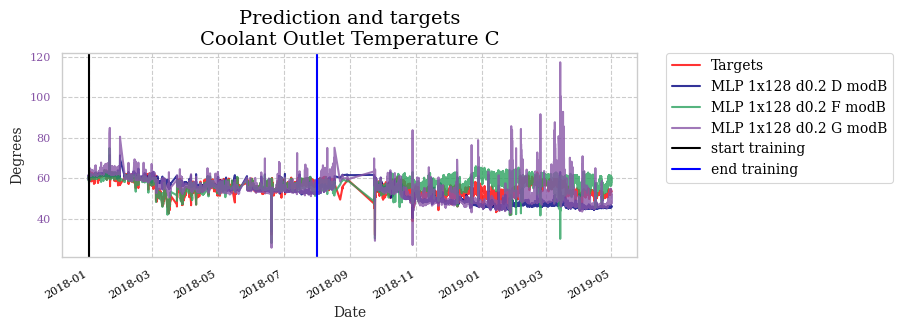

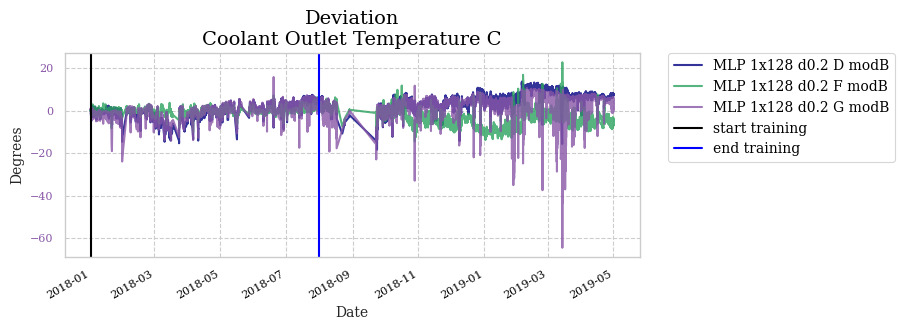

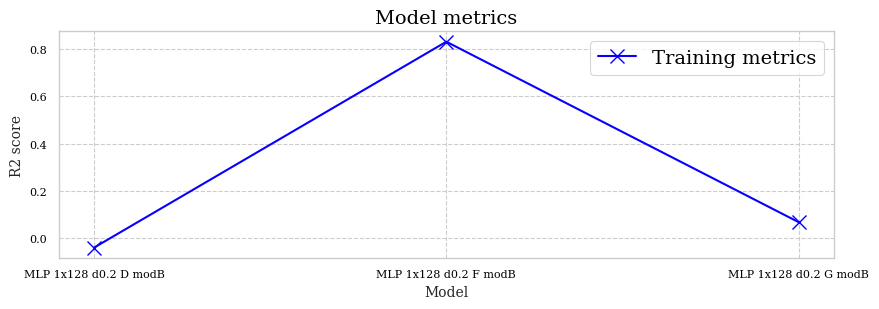


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

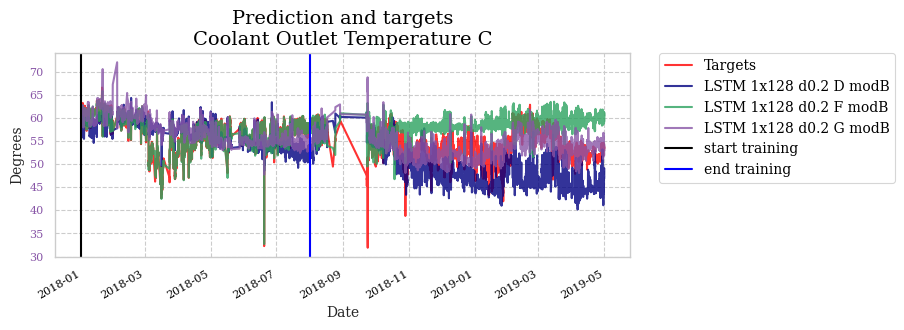

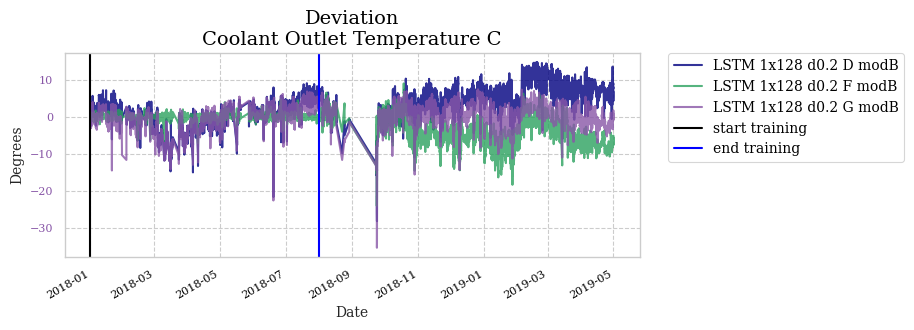

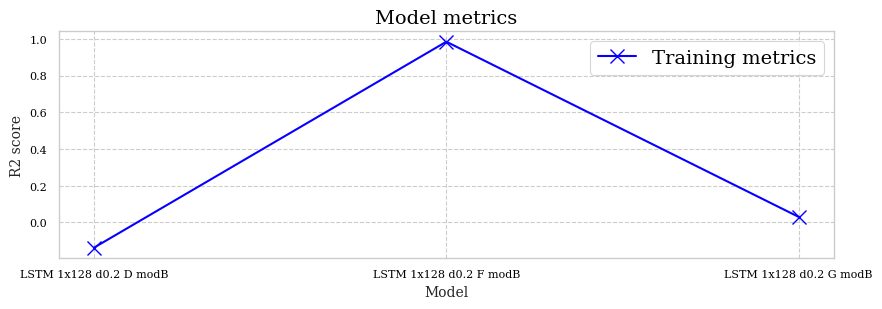


Predictions and deviations for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant 

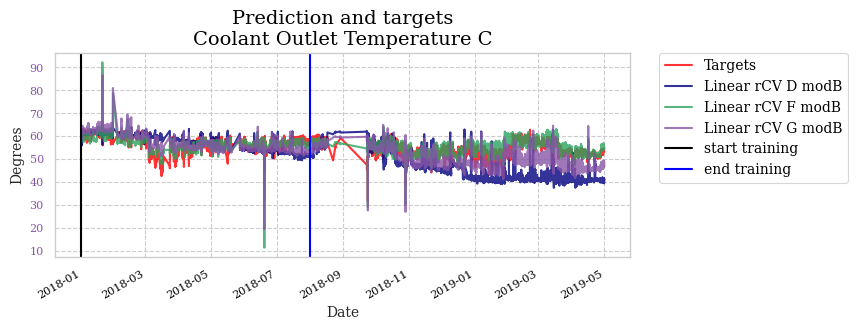

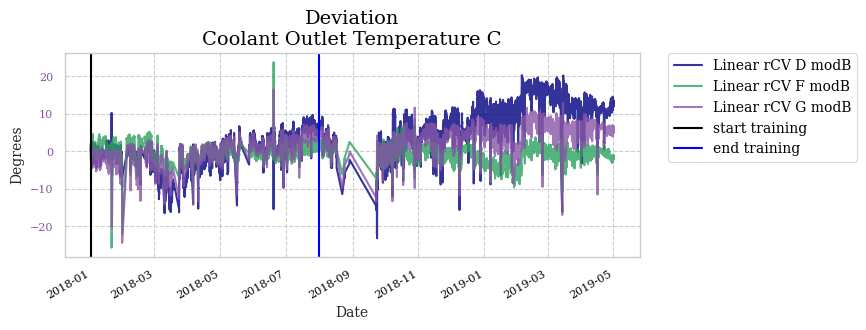

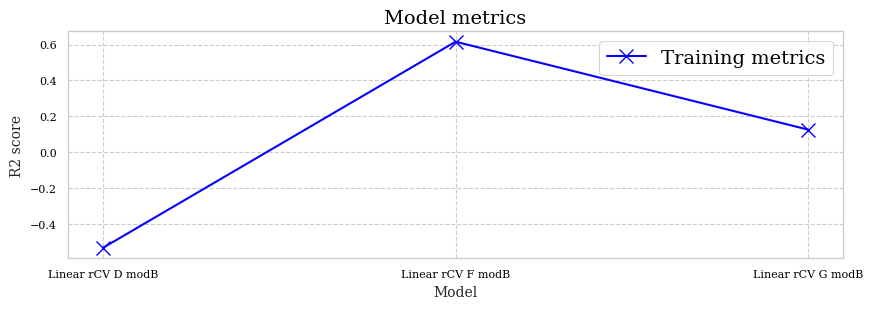

In [9]:
makePredictionsForModAndDir('B', 'F', dirrs, res, retrain=False)

## Discussion, facility F, model B, resolution 30min

For facility F, the MLP model trained on dataset G using predictive model A shows particularly large deviations, often predicting output values wrong by several orders of magnitude, while also displaying large variations. The corresponding MLP model trained on dataset D shows a gradual decrease in predicted value with little variation. LSTM models show some of the same behavior, with gradually decreasing values, although with more variations than the linear model. The same can be said for linear models using predictive model B. Neither model correlates well with the model trained on dataset F.

## Facility G, model B, resolution 30min


Training/loading models for dataset D
Model B
Resolution 30min

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 50TT001 - Coolant Inlet Temperature
Col. 4 : 50TT002 - Coolant Outlet Temperature
Col. 5 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00


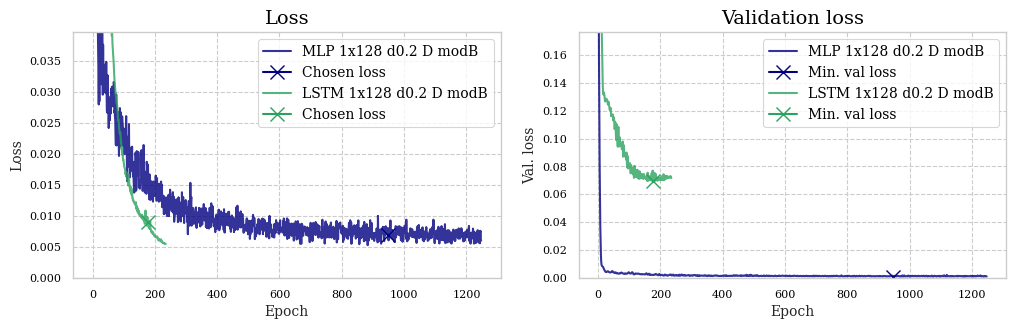


Training/loading models for dataset F
Model B
Resolution 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Val

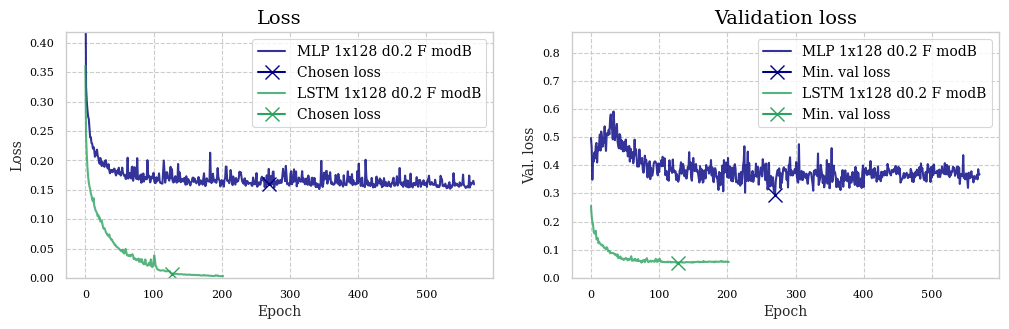


Training/loading models for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLP 1x128 d0.2 G modB was lo

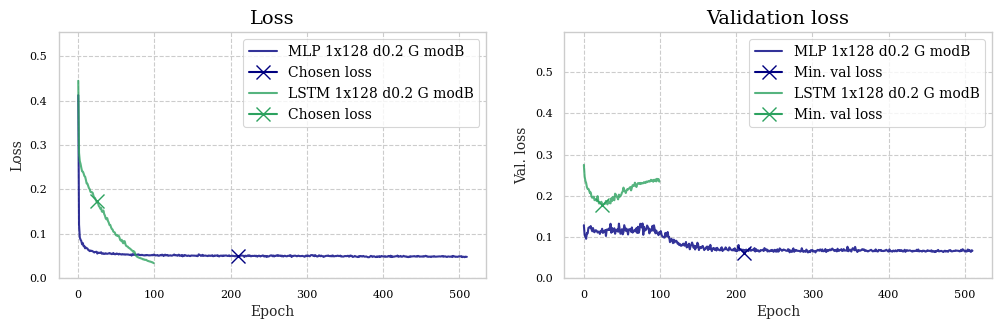


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

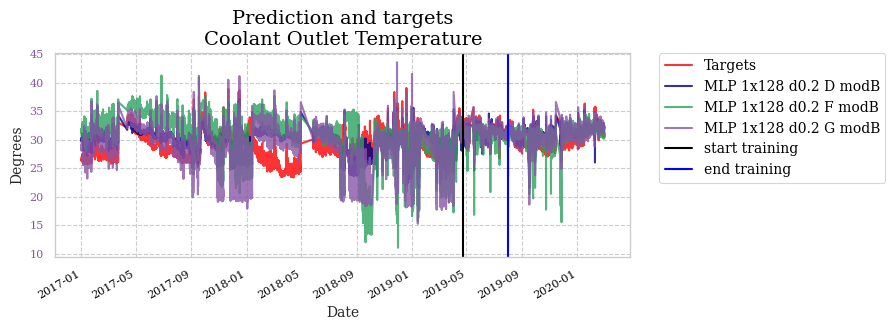

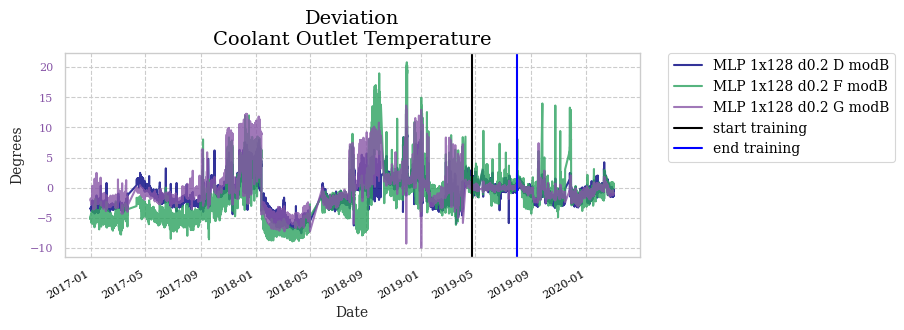

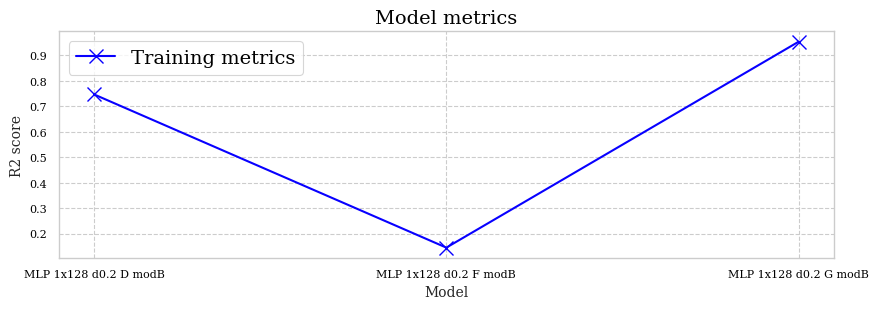


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

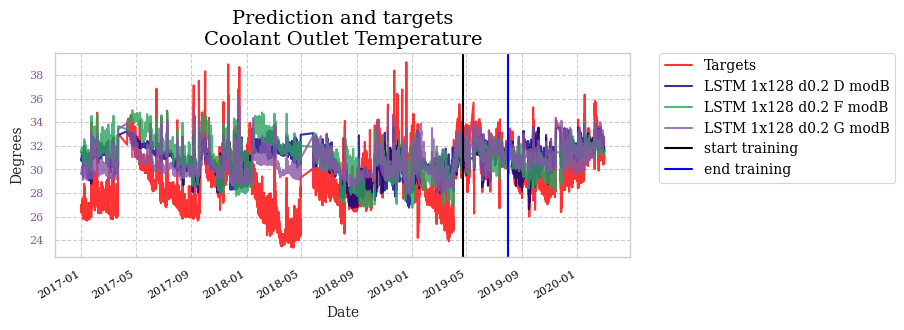

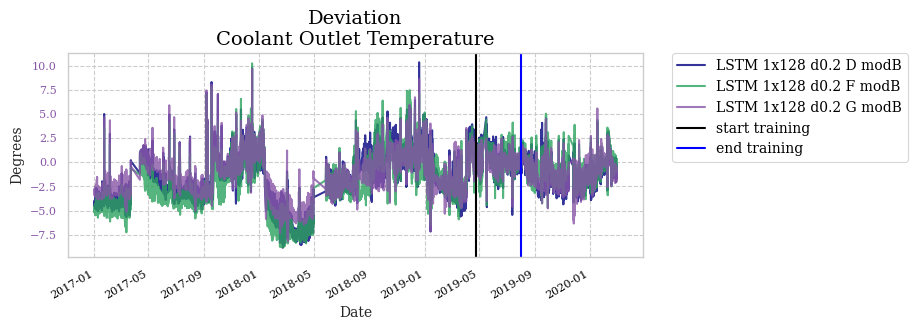

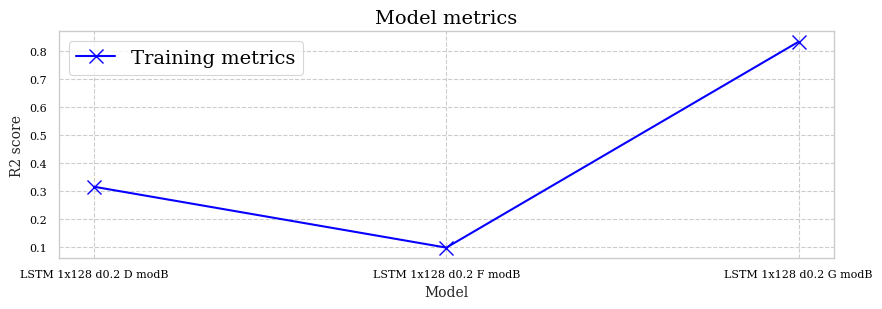


Predictions and deviations for dataset G
Model B
Resolution 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature
Col. 5 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model prediction scores
+------

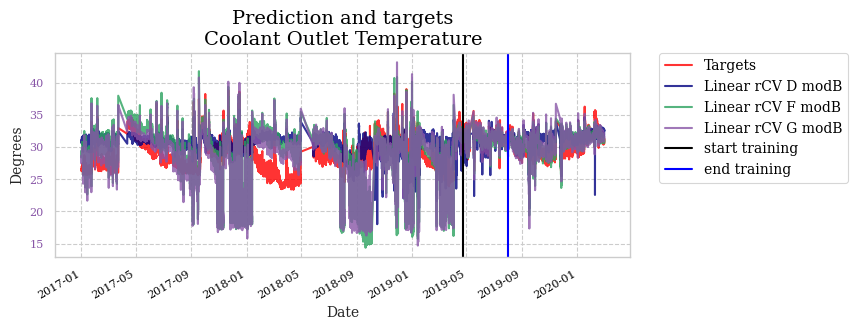

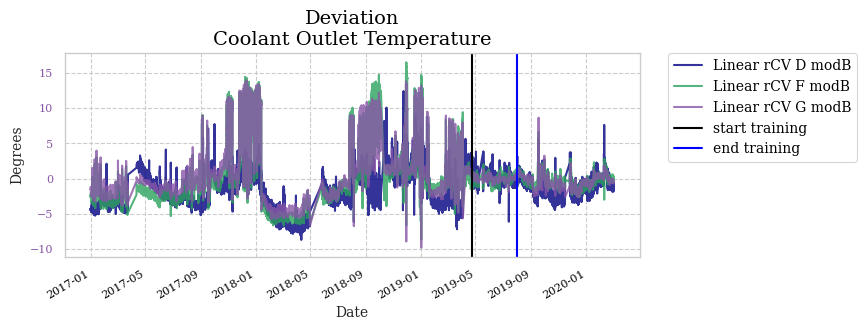

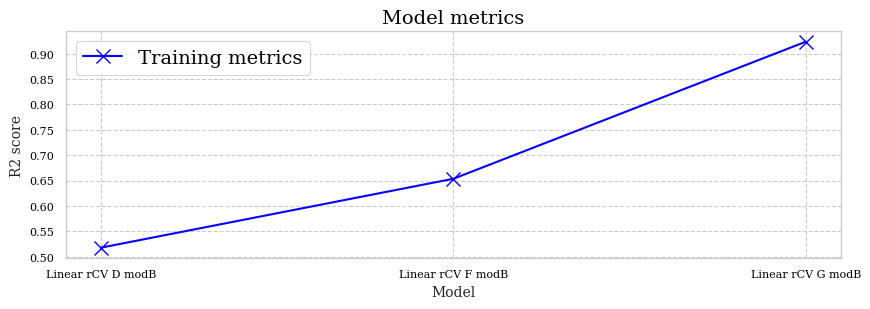

In [10]:
makePredictionsForModAndDir('B', 'G', dirrs, res, retrain=False)

## Discussion, facility G, model B, resolution 30min

It is difficult to evaluate the model performances on facility G appropriately, because the coolant outlet temperature itself is decreasing in a pattern somewhat similar to the expected fouling pattern. This means almost any predictor, even one predicting a constant value, may result in a deviation graph which corresponds to the assumed fouling levels. Even when considering this, cross model prediction for facility G appears more promising than for the facilities previously discussed when using predictive model B. The calculated R2 metrics are relatively high considering the models are trained on different datasets. For MLP models, models trained on dataset D and F show less signs of overfitting to the valve opening value than the model trained on dataset G. All LSTM models show almost the same prediction pattern, although with some static differences. The deviation curves have very similar patterns. The predictions may become even more accurate if static differences are accounted for by adding a derived constant term to the predictions for each model. Linear models seem to have much of the same valve opening overfitting problems.

# Conclusions

Performing predictions with models trained on different datasets gives unsatisfying results in general. Even so, there are some chases for which the pattern of prediction are quite similar. This indicates that predictions using models trained on different datasets may perhaps be utilized in cases where the processing plants are known to have many similarities. Performing predictions in this manner is particularly relevant in cases where a dataset has no apparent training phase. In new facilities, this technique may be the only suitable manner of applying predictive models until adequate training data is acquired. Further investigation is required in order to determine the applicability of such models.